**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Train and Evaluate Model](#2-bullet)
3. [Predictions](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('LCS DATASET PATH', sep='\t', index_col=0)

In [3]:
df.head()

,Open,High,Low,Close,Volume,TradingDate,Code
0,16200.0,19800.0,15750.0,19350.0,278800,2010-07-06,LCS
1,19400.0,19400.0,19400.0,19400.0,30700,2010-07-07,LCS
2,20750.0,20750.0,18450.0,18900.0,192800,2010-07-08,LCS
3,18900.0,18900.0,18900.0,18900.0,1000,2010-07-09,LCS
4,17600.0,18900.0,17600.0,18230.0,133500,2010-07-12,LCS


In [4]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')

In [5]:
df = df.dropna()

In [6]:
# Create a new dataframe
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

In [7]:
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [8]:
scaled_data

array([[ 4.06607813],
       [ 4.07990553],
       [ 3.9416315 ],
       ...,
       [-1.11919787],
       [-1.11919787],
       [-1.11919787]])

## 2. [Train and Evaluate Model](#2-bullet)

### Create dataset

In [9]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

In [11]:
training_size=int(len(dataset)*0.8)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2829, 1)
test_data:  (708, 1)


In [12]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (2798, 30)
y_train:  (2798, 1)
x_test:  (677, 30)
y_test (677, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [13]:
# Create and train the SVR model
svr_model = SVR(C = 1, kernel = 'linear', gamma = 0.01)
svr_model.fit(x_train, y_train)

SVR(C=1, gamma=0.01, kernel='linear')

In [14]:
predictions = svr_model.predict(x_test)
predictions = predictions.reshape(-1,1)

predictions_train = svr_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)

In [15]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [16]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

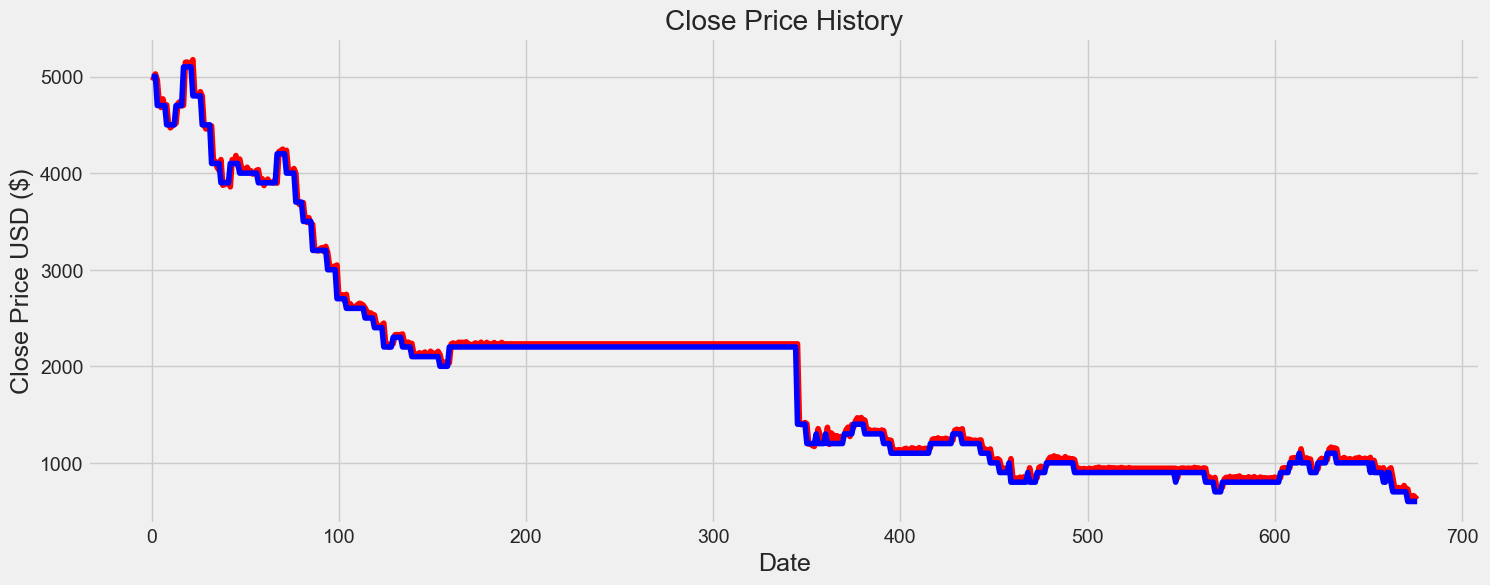

In [17]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [18]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [19]:
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.04295331145755697
Train Mean Squared Error: 0.005226366198273459
Train R-squared: 0.9947736338017266


In [20]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.02404236385124905
Test Mean Squared Error: 0.0032370327134391627
Test R-squared: 0.9967629672865609


## 3. [Predictions](#4-bullet)

In [21]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [22]:
last_60_days = np.array([y_test[i] for i in range(-1, -61, -1)])
next_days = []
for i in range(60):
    input_data = x_test[i-60].reshape(-1,30)

    predicted_price = svr_model.predict(input_data)
    next_days.append(predicted_price)

#
# pop_price = next_days.pop(0)
print("Predicted prices for the next days:")

for i, price in enumerate(next_days):
    price = scaler.inverse_transform(price.reshape(-1,1))
    print(f"Day {i+1}: {price}")

next_days = scaler.inverse_transform(np.array(next_days).reshape(-1,1))

Predicted prices for the next days:
Day 1: [[1753.12246194]]
Day 2: [[1744.68564476]]
Day 3: [[1741.62804691]]
Day 4: [[1651.99009878]]
Day 5: [[1639.12765807]]
Day 6: [[1644.63230397]]
Day 7: [[1643.04882074]]
Day 8: [[1732.9187667]]
Day 9: [[1749.1636595]]
Day 10: [[1741.02642446]]
Day 11: [[1744.38183025]]
Day 12: [[1733.98547397]]
Day 13: [[1841.17778046]]
Day 14: [[1858.58612531]]
Day 15: [[1847.65194022]]
Day 16: [[1850.81166553]]
Day 17: [[1843.19546461]]
Day 18: [[1742.38302617]]
Day 19: [[1742.04519092]]
Day 20: [[1743.19022293]]
Day 21: [[1757.79809361]]
Day 22: [[1734.0809611]]
Day 23: [[1739.9437208]]
Day 24: [[1745.54261211]]
Day 25: [[1738.96589346]]
Day 26: [[1720.93003314]]
Day 27: [[1750.37214064]]
Day 28: [[1749.69670048]]
Day 29: [[1758.45936817]]
Day 30: [[1742.82163725]]
Day 31: [[1733.96117805]]
Day 32: [[1750.09205252]]
Day 33: [[1744.28105857]]
Day 34: [[1735.16809483]]
Day 35: [[1758.8139354]]
Day 36: [[1655.08625896]]
Day 37: [[1729.65456645]]
Day 38: [[1657.2

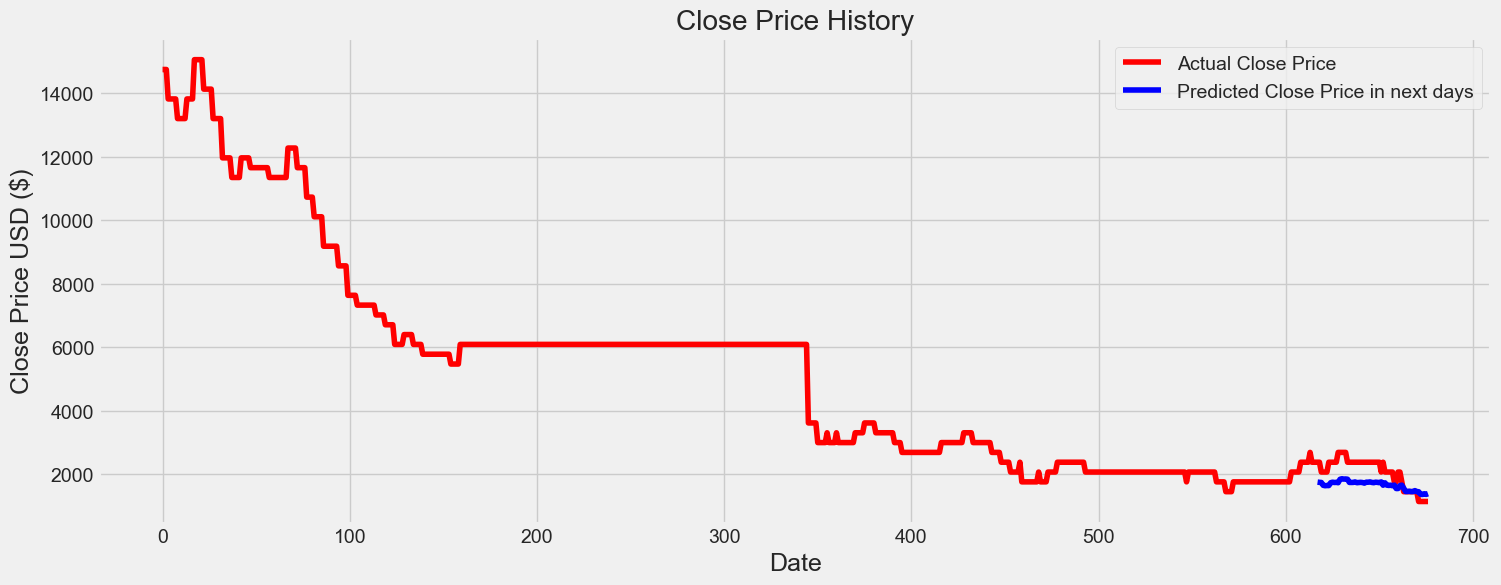

In [23]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(y_test[:], color='red', label='Actual Close Price')
plt.plot(range(len(y_test)-60, len(y_test)), next_days, color='blue', label='Predicted Close Price in next days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()